# One-dimensional convolutions

In this short post we build on our previous discussion of [single-dimensional moving averages](https://jermwatt.github.io/control-notes/posts/moving_averages/Moving_averages.html) by describing their generalization as single-dimensional *convolutions*.  As in that prior post here we too will be working with a generic ordered sequence of $P$ points denoted as

\begin{equation}
x_1,\, x_2,\, \ldots,\, x_P.
\end{equation}

You can skip around this document to particular subsections via the hyperlinks below.

-  [Generalizing the moving average](#generalizing-moving-average)
-  [Common convolution filters](#common-filters)

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library for animations
import sys
sys.path.append('../../')
from demo_libraries import timeseries_library as tlib
import matplotlib.pyplot as plt

# import standard libs
import numpy as np
import pandas as pd
from IPython.display import clear_output

# path to data
datapath = '../../datasets/plain_timeseries/'

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

<a id='generalizing-moving-average'></a>
## Generalizing the moving average

In our previous [post on moving averages](https://jermwatt.github.io/control-notes/posts/moving_averages/Moving_averages.html)) we saw the moving average of *order* or *window-length* $D$ is itself a sequence of the same length, with its first $D$ values equal to the sequence itself as

\begin{equation}
h_p = x_p \,\,\,\,\,\, p=1,...,D.
\end{equation}


and in general for $p \geq D+1$ we have 


\begin{equation}
h_{p} = \frac{x_{p-1} + x_{p-2} + \cdots + x_{p-D}}{D}.
\end{equation}

The functionality used here (the simple *average*) can in principle be replaced with any general function one desires.  However if we swap out the average with something just slightly more complicated (relatively speaking) than a straight-up average - a *linear combination* - we would instead compute updates of the form

\begin{equation}
h_{p} = w_1x_{p-1} + w_2x_{p-2} + \cdots + w_{D}x_{p-D}.
\end{equation}

Here the weights $w_1,\,w_2,\,...,w_{D}$ can be set however we please, and if set to $w_d = \frac{1}{D}$ for all $d$ we recover the moving average update above.

The set of such linear combinations are often referred to as *convolutions*, and the weights $w_1,\,...,w_{D}$ as *filters* or *kernels* (see [endnotes](#endnotes) for further discussion of this term).  

Like the moving average, convolutions *dynamic systems* that are often used to smooth and - more generally - clean up time series for further processing.  As with the moving average, general convolutions 

<a id='common-filters'></a>
## Common convolution filters

In [2]:
## This code cell will not be shown in the HTML version of this notebook
def plot_weights(weights,title):
    # create figure
    fig = plt.figure(figsize = (9,4))
    O = len(weights)
    x = np.arange(1,O+1,1)

    # scatter weights
    plt.scatter(x,weights,s=80,c='k',edgecolor='w',linewidth=1,zorder=1)
    for i in range(len(weights)):
        xv = x[i]
        yv = weights[i]
        plt.plot((xv,xv),(0,yv),c='k',zorder=0,linestyle='--')
        
    # cleanup plot
    plt.plot((x[0]-1,x[-1]+1),(0,0),c='k',linewidth=1)
    plt.title(title,fontsize=18)
    plt.xlabel(r'$d$',fontsize=16)
    plt.ylabel(r'$w_d$',fontsize=16,rotation=0,labelpad=20)
    plt.show()

#### <span style="color:#a50e3e;">Example 1: </span>  Average filter 

Viewed through the lens of convolution, a moving average is often referred to as a "mean filter".  Below we produce two Python functions that illustrate this perspective, and allow for immediate generalization to other filters.  The  `mean_weights` function creates a set of "mean weights" used to produce a moving average - that is, the elements of a series in each window of length $D$ are multiplied by these weights.  This function takes in only one input: $D$ the order of the moving average.

In [4]:
# make average weights
def mean_weights(D):
    weights = [1/D for v in range(D)]
    return weights

We can visualize these weights - as shown below for the case where $\mathcal{D} = 10$.  Here each black dot represents a weight value, and the dashed lines are drawn for visualization purposes only.

<IPython.core.display.Javascript object>


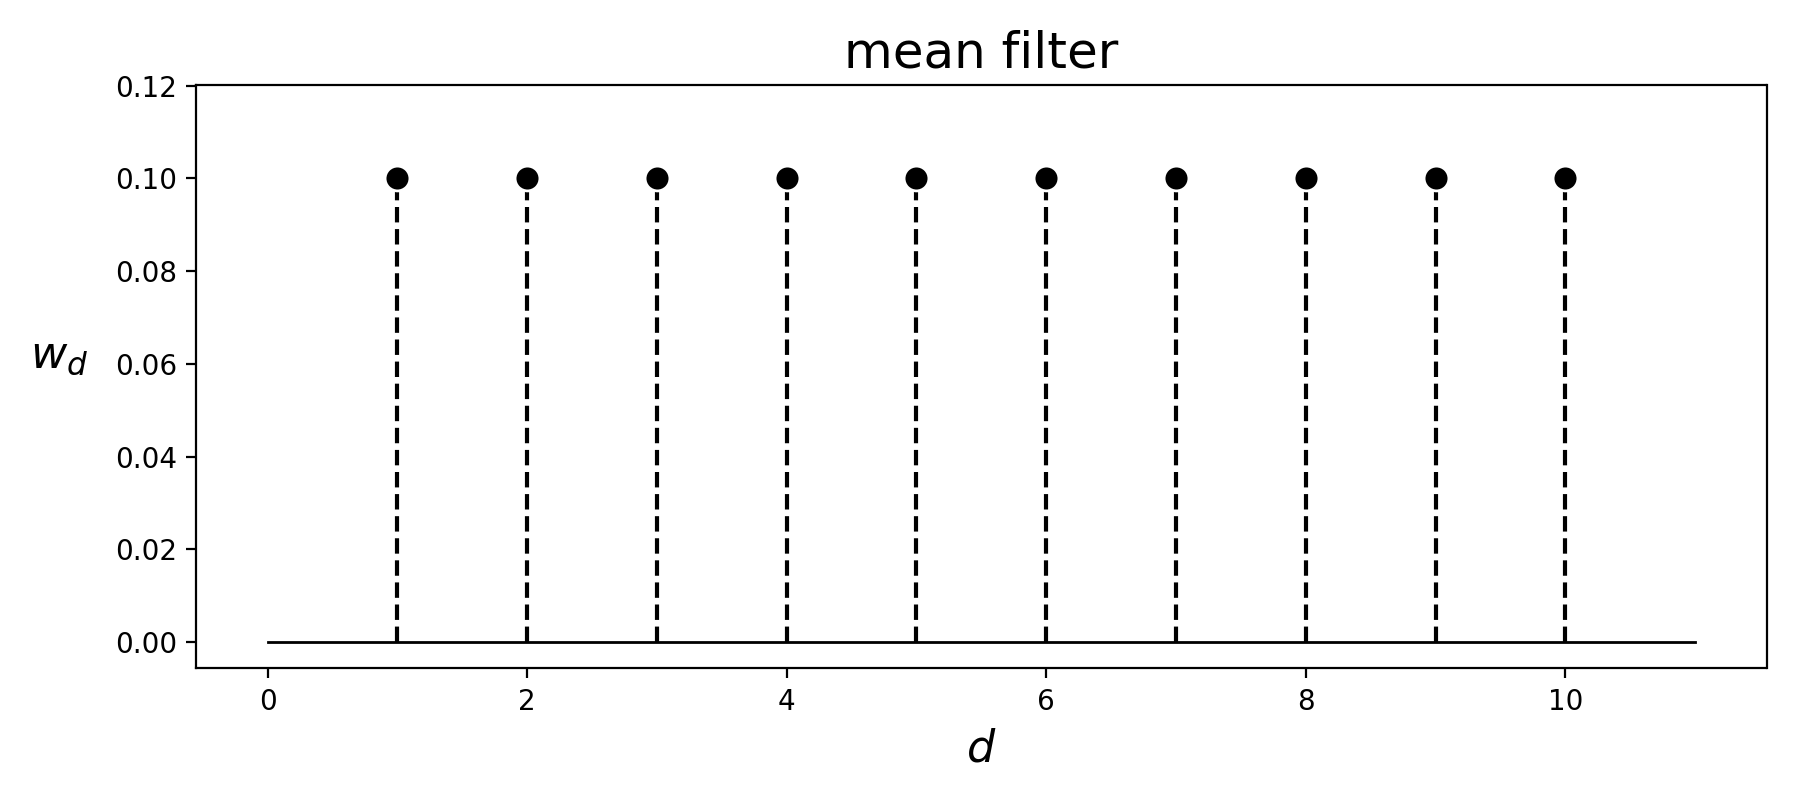

In [8]:
## This code cell will not be shown in the HTML version of this notebook
D = 10
w = mean_weights(D)
plot_weights(w,title='mean filter')

We can then produce a moving average via the `linear_filter` function below - which takes in a time series `x`,  a window length `O`, and a set of filter weights `w`.

In [6]:
# general linear filter function
def linear_filter(x,w):
    # filter input signal
    D = len(w)
    y = [v for v in x[:D]]
    for p in range(len(x) - D):
        # make next element
        b = sum([a*b for a,b in zip(x[p:p+D],w)])
        y.append(b)
    return np.array(y)

This process, animated below for a particular time series, smooths the input time series.  The window in which each average is computed is straddled on both sides by vertical blue bars, and as the animation progresses from left to right across the series the resulting moving average is shown as an orange series.

In [7]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname = datapath + 'ford_data.csv'
data = pd.read_csv(csvname)
x = np.array(data['Close'])    # date: 1975 to 2019

# produce moving average time series
D = 10
w = mean_weights(D)
y = linear_filter(x,w)

# run animator
demo = tlib.time_series_animators.Visualizer()
demo.animate_moving_ave(x,y,D,savepath='videos/animation_1.mp4')
clear_output()

In [8]:
## This code cell will not be shown in the HTML version of this notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_1.mp4" type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 2: </span>  Sinc filter 

Other popular choices for weights outside of the average include average cosine and sinc weights.  These arise naturally in the study of [signal processing](http://sam-koblenski.blogspot.com/2015/09/everyday-dsp-for-programmers-averaging.html) where they go by names like ["low pass filtering"](https://en.wikipedia.org/wiki/Low-pass_filter).  To create such weights we sample an elementary function, like for example the sinc function shown below for $D=30$, and multiply the resulting weights by windowed portions of our input series precisely as we did with the original moving average weights above.

In [9]:
## This code cell will not be shown in the HTML version of this notebook
# compute centered sinc weights
def sinc_weights(D,**kwargs):
    v = np.arange(0.5-D/2,D/2,1)
    freq = 1
    if 'freq' in kwargs:
        freq = kwargs['freq']
    weights = []
    for o in v:
        spot = o/D
        if np.abs(spot) < 10**(-8):
            spot = 1
        h = np.sin(2*np.pi*freq*spot)/(2*np.pi*freq*spot)
        weights.append(h)
    
    # normalize
    h_sum = sum(weights)
    weights = [h/h_sum for h in weights]
    return weights

<IPython.core.display.Javascript object>


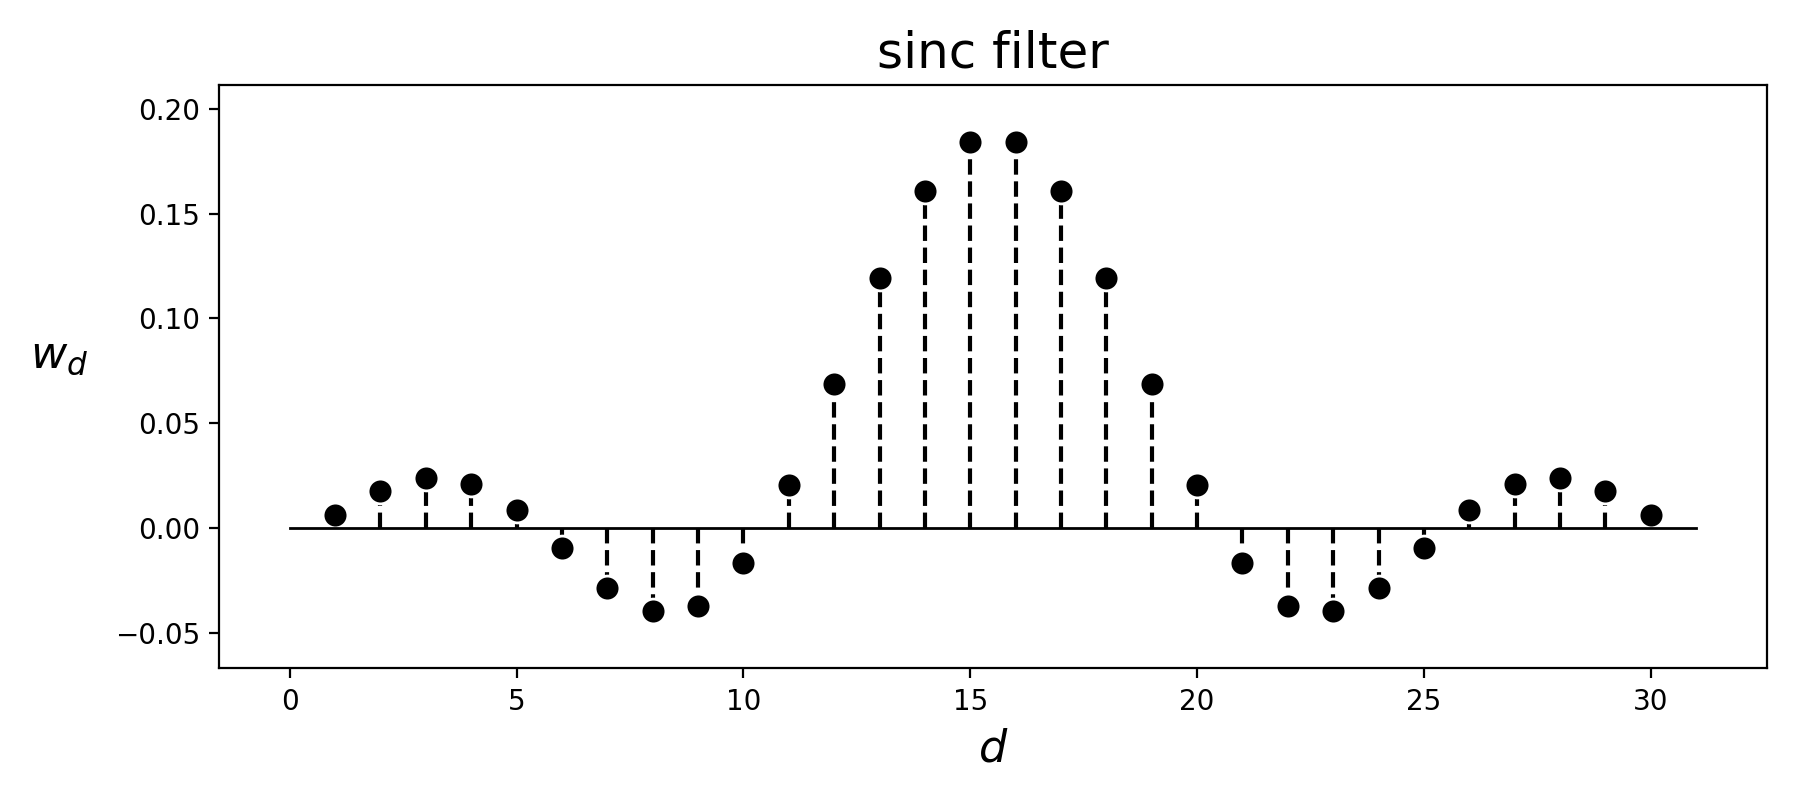

In [12]:
## This code cell will not be shown in the HTML version of this notebook
D = 30
w = sinc_weights(D,freq=3)
plot_weights(w,title='sinc filter')

To produce this set of sinc weights we simply adjust the basic sinc function, and divide off the order of the window as shown below.

In [10]:
# compute centered sinc weights
def sinc_weights(D,**kwargs):
    v = np.arange(0.5-D/2,D/2,1)
    freq = 1
    if 'freq' in kwargs:
        freq = kwargs['freq']
    weights = []
    for o in v:
        spot = o/D
        if np.abs(spot) < 10**(-8):
            spot = 1
        h = np.sin(2*np.pi*freq*spot)/(2*np.pi*freq*spot)
        weights.append(h)
    
    # normalize
    h_sum = sum(weights)
    weights = [h/h_sum for h in weights]
    return weights

This set of weights will smooth an input series, leaving a more trigonometric fit than the moving average.

In [11]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname = datapath + 'ford_data.csv'
data = pd.read_csv(csvname)
x = np.array(data['Close'])    # date: 1975 to 2019

# produce moving average time series
D = 10
w = sinc_weights(D,freq=1)
y = linear_filter(x,w)

# run animator
demo = tlib.time_series_animators.Visualizer()
demo.animate_moving_ave(x,y,D,savepath='videos/animation_2.mp4')
clear_output()

In [12]:
## This code cell will not be shown in the HTML version of this notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_2.mp4" type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 3: </span>  Cosine filter 

By similarly sampling a cosine we can create cosine filter - whose weights are shown below.

<IPython.core.display.Javascript object>


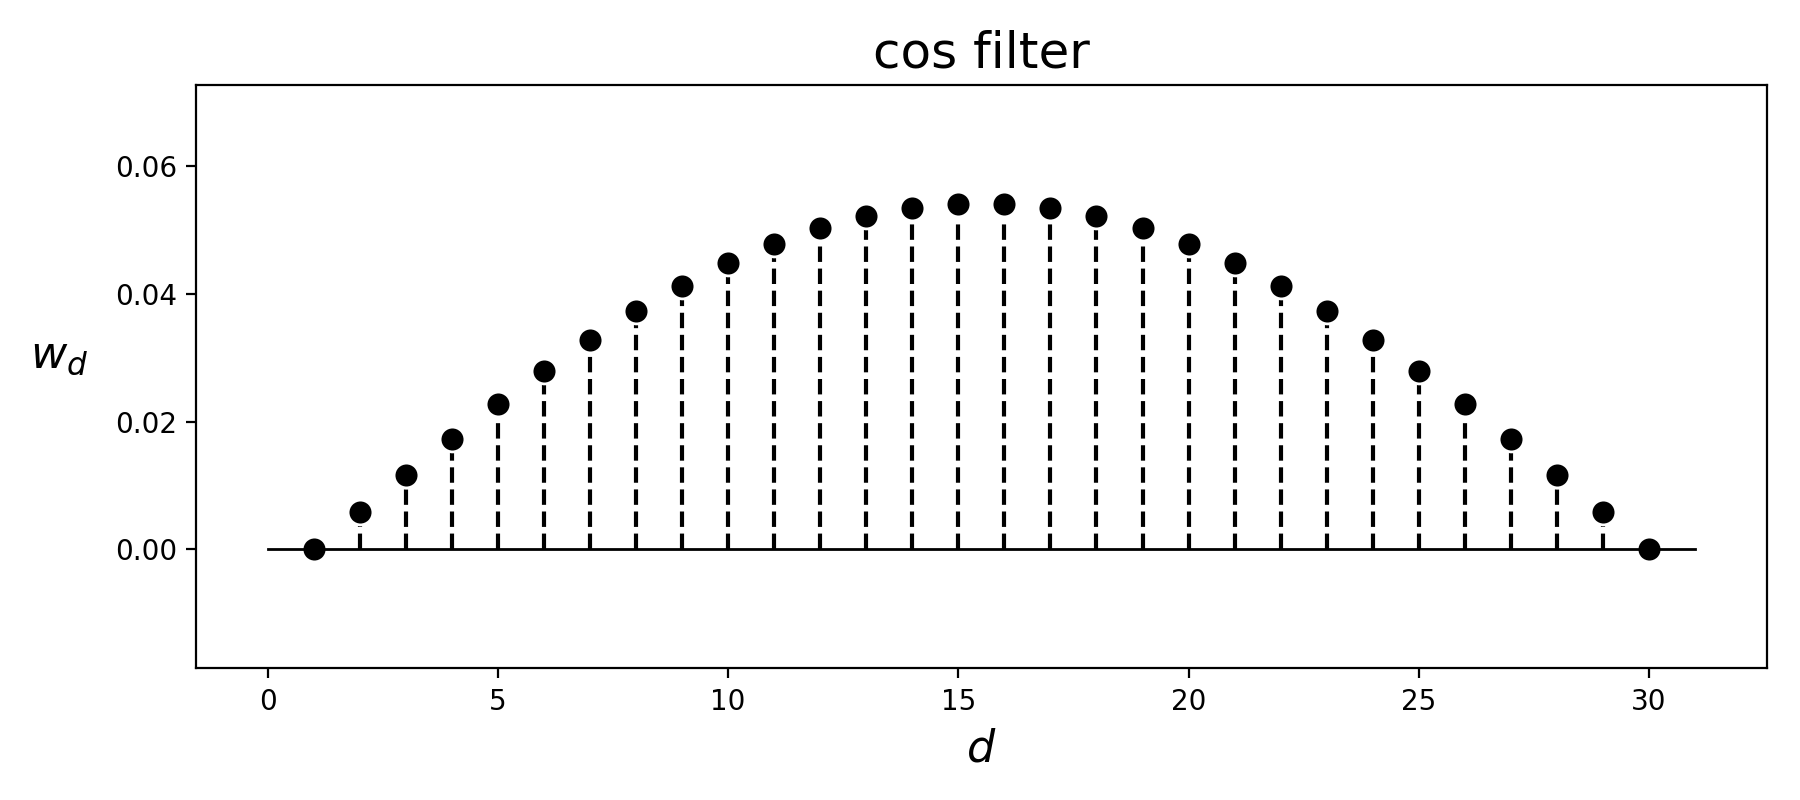

In [15]:
## This code cell will not be shown in the HTML version of this notebook
# produce cosine weights
def cos_weights(D,**kwargs):
    v = np.linspace(-np.pi/2,np.pi/2,D)
    freq = 1
    if 'freq' in kwargs:
        freq = kwargs['freq']
    weights = []
    for o in v:
        h = np.cos(o)
        weights.append(h)
    
    # normalize
    h_sum = sum(weights)
    weights = [h/h_sum for h in weights]
    return weights

# plot weights
D = 30
w = cos_weights(D)
plot_weights(w,title='cos filter')

<a id='endnotes'></a>

## Endnotes

The general linear combination in Equation (4) is more accurately known as *cross-correlation*, which is closely related to the convolution operation which is more commonly defined as

\begin{equation}
h_{p} = w_{D}x_{p-1} + w_{D-1}x_{p-2} + \cdots + w_{1}x_{p-D}.
\end{equation}

Here the weight sequence $w$ has been reversed before being multiplied by the elements of $x$.  Flipping the order of the weights makes for a more awkward formula, and gaurntees certain mathematical niceties like   e.g., the [commutative property](https://en.wikipedia.org/wiki/Convolution).  But because these mathematical ideas do not concern us - and for the sake of clarity in notation - we mish-mash the terms corss-correlation and convolution.